### Import libraries and create DataFrame from csv 

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prompt user for week selection
start_week = int(input("Enter the start week for analysis: "))
end_week = int(input("Enter the end week for analysis (enter the same as start week for single week analysis): "))
weeks = str(start_week) if start_week == end_week else f"{start_week} - {end_week}"

# Function to read, preprocess, group by player, and aggregate data for the selected weeks
def read_data(start_week, end_week):
    data = pd.DataFrame()

    for week in range(start_week, end_week + 1):
        temp_df = pd.read_excel("RB_Data.xlsx", sheet_name=f"Week{week}")

        # Preprocess: Drop irrelevant columns and convert data types
        temp_df.drop(['FL', 'ROST'], axis=1, inplace=True)
        convert = temp_df.select_dtypes('object').columns.difference(['Player'])
        temp_df[convert] = temp_df[convert].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce')).fillna(0)
        temp_df['Rank'] = temp_df['Rank'].astype('Int64')

        # Group by 'Player' and aggregate data
        if data.empty:
            data = temp_df
        else:
            data = data.merge(temp_df, on='Player', suffixes=('', '_week' + str(week)))

    # Apply custom aggregation logic
    for column in data.columns:
        if column.endswith(tuple([f'_week{week}' for week in range(start_week + 1, end_week + 1)])):
            base_column = column.split('_week')[0]
            if base_column in ['Rank', 'Player']:  # Take the latest value
                data[base_column] = data[column]
            elif base_column in ['LG']:  # Take the maximum value
                data[base_column] = data[[base_column, column]].max(axis=1)
            else:  # Sum the values
                data[base_column] += data[column]
            data.drop(column, axis=1, inplace=True)  # Drop the extra week column

    # Calculate 'Y/A' and 'Y/R' based on summed values
    data['Y/A'] = (data['YDS'] / data['ATT']).round(1)
    data['Y/R'] = (data['YDS.1'] / data['REC']).round(1)
    data['FPTS/G'] = (data['FPTS'] / data['G']).round(1)

    return data

# Load and aggregate data for the selected weeks
df = read_data(start_week, end_week)

# Recalculate 'Rank' based on 'FPTS' in descending order
df['Rank'] = df['FPTS'].rank(ascending=False, method='min').astype('int')

# Create 'Weeks' column
if start_week == end_week:
    df['Weeks'] = str(start_week)
else:
    df['Weeks'] = f"{start_week} - {end_week}"

df = df.sort_values(by='Rank')
df.head(10)

,Rank,Player,ATT,YDS,Y/A,LG,20+,TD,REC,TGT,YDS.1,Y/R,TD.1,G,FPTS,FPTS/G,Weeks
0,1,Rachaad White (TB),64,254,4.0,38,2,3,14,16,131,9.4,1,4,76.5,19.1,9 - 12
178,2,Christian McCaffrey (SF),56,287,5.1,27,1,2,16,21,97,6.1,1,3,72.4,24.1,9 - 12
17,3,Brian Robinson Jr. (WAS),58,227,3.9,18,0,1,16,20,193,12.1,1,4,68.0,17.0,9 - 12
13,4,Jaylen Warren (PIT),48,367,7.6,74,7,2,11,13,63,5.7,0,4,64.0,16.0,9 - 12
2,5,Josh Jacobs (LV),87,363,4.2,63,7,3,7,9,38,5.4,0,4,63.1,15.8,9 - 12
37,6,Devin Singletary (HOU),71,306,4.3,22,2,2,11,13,71,6.5,0,4,60.7,15.2,9 - 12
8,7,Joe Mixon (CIN),49,168,3.4,15,0,2,14,16,105,7.5,1,4,59.3,14.8,9 - 12
139,8,Jahmyr Gibbs (DET),33,167,5.1,35,3,3,13,19,113,8.7,0,3,59.0,19.7,9 - 12
3,9,Austin Ekeler (LAC),53,210,4.0,37,3,3,13,23,109,8.4,0,4,58.9,14.7,9 - 12
1,10,Rhamondre Stevenson (NE),50,273,5.5,64,4,2,12,16,65,5.4,0,3,57.8,19.3,9 - 12


### Convert relevant stats to a per-game basis and create the final stats for analysis

In [42]:
# Define columns for per-game calculation
per_game = list(df.columns[2:])

# Define columns to exclude from the per-game calculation
exclude_per_game = ['Y/A', 'LG', 'Y/R', 'G', 'FPTS', 'FPTS/G', 'Weeks']

# Create columns and convert stats to a per-game basis for the defined columns, not those in the exclude list
for col in per_game:
    if col not in exclude_per_game:
        df[col + '/game'] = (df[col] / df['G']).round(1)

# Define final columns to be used for analysis, combines excluded and new per-game columns
final_columns = exclude_per_game + [col + '/game' for col in per_game if col not in exclude_per_game]

# Display final columns with 'Rank' and 'Player'
df[['Rank', 'Player'] + final_columns].head(10)

,Rank,Player,Y/A,LG,Y/R,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
0,1,Rachaad White (TB),4.0,38,9.4,4,76.5,19.1,9 - 12,16.0,63.5,0.5,0.8,3.5,4.0,32.8,0.2
178,2,Christian McCaffrey (SF),5.1,27,6.1,3,72.4,24.1,9 - 12,18.7,95.7,0.3,0.7,5.3,7.0,32.3,0.3
17,3,Brian Robinson Jr. (WAS),3.9,18,12.1,4,68.0,17.0,9 - 12,14.5,56.8,0.0,0.2,4.0,5.0,48.2,0.2
13,4,Jaylen Warren (PIT),7.6,74,5.7,4,64.0,16.0,9 - 12,12.0,91.8,1.8,0.5,2.8,3.2,15.8,0.0
2,5,Josh Jacobs (LV),4.2,63,5.4,4,63.1,15.8,9 - 12,21.8,90.8,1.8,0.8,1.8,2.2,9.5,0.0
37,6,Devin Singletary (HOU),4.3,22,6.5,4,60.7,15.2,9 - 12,17.8,76.5,0.5,0.5,2.8,3.2,17.8,0.0
8,7,Joe Mixon (CIN),3.4,15,7.5,4,59.3,14.8,9 - 12,12.2,42.0,0.0,0.5,3.5,4.0,26.2,0.2
139,8,Jahmyr Gibbs (DET),5.1,35,8.7,3,59.0,19.7,9 - 12,11.0,55.7,1.0,1.0,4.3,6.3,37.7,0.0
3,9,Austin Ekeler (LAC),4.0,37,8.4,4,58.9,14.7,9 - 12,13.2,52.5,0.8,0.8,3.2,5.8,27.2,0.0
1,10,Rhamondre Stevenson (NE),5.5,64,5.4,3,57.8,19.3,9 - 12,16.7,91.0,1.3,0.7,4.0,5.3,21.7,0.0


### Calculate the correlations for the final stats across different conditions

In [43]:
# Define columns and columns to exclude for correlation calculation, from final columns
exclude_corr = ['FPTS/G', 'FPTS', 'G', 'Weeks']
corr_columns = [col for col in final_columns if col not in exclude_corr]

# Define a function to calculate correlations
def compute_correlations(dataframe, corr_columns):
    return dataframe[corr_columns].corrwith(dataframe['FPTS/G'])

# Compute correlations for various conditions
corr_all = compute_correlations(df, corr_columns)
corr_nonzero = compute_correlations(df[df['FPTS/G'] > 0], corr_columns)
corr_top50 = compute_correlations(df[df['Rank'] <= 50], corr_columns)
corr_top25 = compute_correlations(df[df['Rank'] <= 25], corr_columns)

# Compile all correlations into a DataFrame for comparison
df_corr = pd.DataFrame({
    'All Players': corr_all,
    'FPTS > 0': corr_nonzero,
    'Top 50 Players': corr_top50,
    'Top 25 Players': corr_top25
})

# Calculate the average correlation across the four conditions, adding 'Average' column to DataFrame
df_corr['Correlation'] = df_corr.mean(axis=1)

df_corr.round(2)

,All Players,FPTS > 0,Top 50 Players,Top 25 Players,Correlation
Y/A,0.33,0.32,0.51,0.08,0.31
LG,0.77,0.71,0.51,0.15,0.54
Y/R,0.19,0.18,0.06,0.13,0.14
ATT/game,0.86,0.83,0.54,0.47,0.68
YDS/game,0.93,0.92,0.82,0.54,0.80
20+/game,0.67,0.67,0.68,-0.04,0.49
TD/game,0.66,0.64,0.37,0.36,0.51
REC/game,0.81,0.76,0.56,0.37,0.62
TGT/game,0.81,0.76,0.50,0.39,0.62
YDS.1/game,0.79,0.75,0.57,0.35,0.61


### Assign the weights for the final stats

In [44]:
# Calculate R^2 for the 'Average' correlation, adding 'R^2' column to DataFrame
df_corr['R^2'] = df_corr['Correlation'] ** 2

# Define the calculation to assign weights
def weight_calc(row):
    if row['Correlation'] >= 0.69:
        return 1 + row['R^2']
    else:
        return 1
    
# Assign weights based on the given criteria, adding 'Weight' column to DataFrame
df_corr['Weight'] = df_corr.apply(weight_calc, axis=1)

# Display the new columns in the DataFrame
df_corr[['Correlation', 'R^2', 'Weight']].round(2)

,Correlation,R^2,Weight
Y/A,0.31,0.10,1.00
LG,0.54,0.29,1.00
Y/R,0.14,0.02,1.00
ATT/game,0.68,0.46,1.00
YDS/game,0.80,0.64,1.64
20+/game,0.49,0.24,1.00
TD/game,0.51,0.26,1.00
REC/game,0.62,0.39,1.00
TGT/game,0.62,0.38,1.00
YDS.1/game,0.61,0.38,1.00


### Multiply the assigned weights to the final stats

In [45]:
# Multiply each relevant column by its corresponding weight
for col in corr_columns:
    weight = df_corr.loc[col, 'Weight']
    df[col + '_weighted'] = (df[col] * weight).round(1)

# Extract the weighted columns
weight_columns = [col + '_weighted' for col in corr_columns]

# Display the new weighted stats columns
df_weight = df[['Rank', 'Player', 'FPTS/G'] + weight_columns]
df_weight.sort_values(by=['FPTS/G'],ascending=False).head(10)

,Rank,Player,FPTS/G,Y/A_weighted,LG_weighted,Y/R_weighted,ATT/game_weighted,YDS/game_weighted,20+/game_weighted,TD/game_weighted,REC/game_weighted,TGT/game_weighted,YDS.1/game_weighted,TD.1/game_weighted
157,28,Kyren Williams (LAR),38.4,8.9,56.0,10.2,16.0,234.9,5.0,0.0,6.0,6.0,61.0,2.0
178,2,Christian McCaffrey (SF),24.1,5.1,27.0,6.1,18.7,157.2,0.3,0.7,5.3,7.0,32.3,0.3
139,8,Jahmyr Gibbs (DET),19.7,5.1,35.0,8.7,11.0,91.5,1.0,1.0,4.3,6.3,37.7,0.0
1,10,Rhamondre Stevenson (NE),19.3,5.5,64.0,5.4,16.7,149.5,1.3,0.7,4.0,5.3,21.7,0.0
0,1,Rachaad White (TB),19.1,4.0,38.0,9.4,16.0,104.3,0.5,0.8,3.5,4.0,32.8,0.2
6,15,Jonathan Taylor (IND),17.8,3.7,17.0,4.7,18.7,113.3,0.0,1.0,2.0,2.0,9.3,0.3
17,3,Brian Robinson Jr. (WAS),17.0,3.9,18.0,12.1,14.5,93.3,0.0,0.2,4.0,5.0,48.2,0.2
35,17,Bijan Robinson (ATL),16.9,4.8,17.0,8.5,16.3,129.8,0.0,0.7,2.0,4.0,17.0,0.3
83,19,David Montgomery (DET),16.8,6.7,75.0,11.0,13.0,144.1,1.7,1.0,0.7,1.0,7.3,0.0
13,4,Jaylen Warren (PIT),16.0,7.6,74.0,5.7,12.0,150.8,1.8,0.5,2.8,3.2,15.8,0.0


### Display the columns potentially to be included in the average weighted score

In [46]:
high_corr = df_corr[df_corr['Correlation'] >= 0.69].index.tolist()
conditional_columns = [col + '_weighted' for col in high_corr if col + '_weighted' in df.columns]

# Include 'FPTS/G' in columns to be used for the average weighted score
conditional_columns.append('FPTS/G')

conditional_columns

['YDS/game_weighted', 'FPTS/G']

### Define the columns to be used for the average weighted score

In [47]:
# Define select columns to be used for the average weighted score
# Copy the columns from above
avg = ['ATT/game_weighted',
 'YDS/game_weighted',
 'TD/game_weighted',
 'REC/game_weighted',
 'TGT/game_weighted',
 'YDS.1/game_weighted',
 'FPTS/G']

### Calculate each player's average weighted score and rank them from high to low

In [48]:
# Calculate the average weighted score for the select columns
df['Score'] = df[avg].mean(axis=1).round(1)

# Rank both of the average weighted scores with NaN handling
df['Final Rank'] = df.sort_values('Score', ascending=False)\
                ['Score'].rank(method='first', ascending=False, na_option='bottom').astype(int)

# Calculate the variance in ranking both ranks
df['Variance'] = df['Rank'] - df['Final Rank']

### Display results of the average weighted score and rank

In [49]:
# List of columns to be excluded
final_columns_exclude = ['Y/R', 'LG', 'TD.1/game']

# Exclude the specified columns from final_columns
final_columns = [col for col in final_columns if col not in final_columns_exclude]

# Create final analysis columns
analysis = df[['Rank', 'Final Rank', 'Player', 'Score', 'Variance'] + final_columns]
analysis.set_index('Rank', inplace=True)
analysis = analysis.sort_values(by='Final Rank', ascending=True)

# Export to Excel
analysis.to_excel("RB_Analysis.xlsx", index=False)

# Display the top 30 rows
analysis.head(30)


,Final Rank,Player,Score,Variance,Y/A,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game
Rank,,,,,,,,,,,,,,,,
28,1,Kyren Williams (LAR),51.8,27,8.9,1,38.4,38.4,9 - 12,16.0,143.0,5.0,0.0,6.0,6.0,61.0
2,2,Christian McCaffrey (SF),35.0,0,5.1,3,72.4,24.1,9 - 12,18.7,95.7,0.3,0.7,5.3,7.0,32.3
10,3,Rhamondre Stevenson (NE),31.0,7,5.5,3,57.8,19.3,9 - 12,16.7,91.0,1.3,0.7,4.0,5.3,21.7
4,4,Jaylen Warren (PIT),28.7,0,7.6,4,64.0,16.0,9 - 12,12.0,91.8,1.8,0.5,2.8,3.2,15.8
5,5,Josh Jacobs (LV),28.7,0,4.2,4,63.1,15.8,9 - 12,21.8,90.8,1.8,0.8,1.8,2.2,9.5
17,6,Bijan Robinson (ATL),26.7,11,4.8,3,50.8,16.9,9 - 12,16.3,79.0,0.0,0.7,2.0,4.0,17.0
19,7,David Montgomery (DET),26.3,12,6.7,3,50.5,16.8,9 - 12,13.0,87.7,1.7,1.0,0.7,1.0,7.3
23,8,Raheem Mostert (MIA),26.2,15,4.9,3,46.2,15.4,9 - 12,18.0,88.3,1.0,1.0,0.3,1.3,2.3
6,9,Devin Singletary (HOU),26.1,-3,4.3,4,60.7,15.2,9 - 12,17.8,76.5,0.5,0.5,2.8,3.2,17.8


### Compare per-game stats of two players and visualize the results

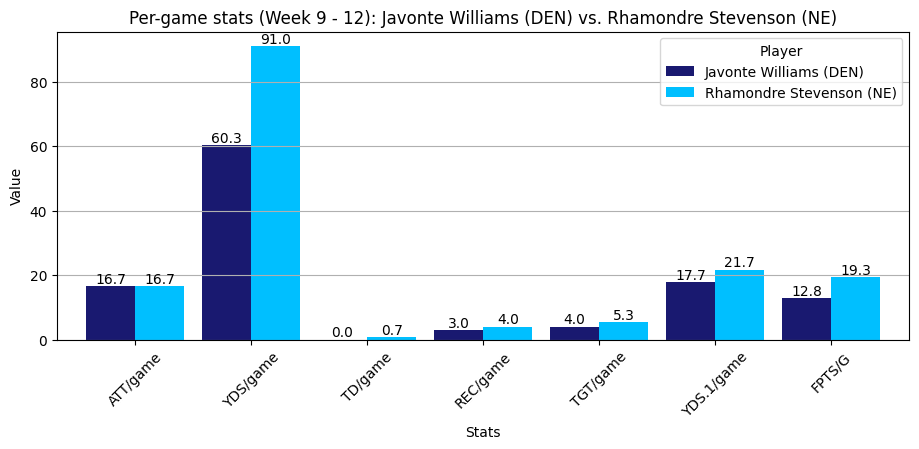

,Final Rank,Y/A,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game
Player,,,,,,,,,,,,,
Javonte Williams (DEN),20,3.6,3,38.4,12.8,9 - 12,16.7,60.3,0.0,0.0,3.0,4.0,17.7
Rhamondre Stevenson (NE),3,5.5,3,57.8,19.3,9 - 12,16.7,91.0,1.3,0.7,4.0,5.3,21.7


In [50]:
# Prompt the user to input the name of the players
player1 = input("Enter player 1 name")
player2 = input("Enter player 2 name")

# Extract and reorder rows for the two specified players
# Filter rows where the 'Player' column contains the names entered by the user
players = df[df['Player'].str.contains(player1) | df['Player'].str.contains(player2)]
players.set_index('Player', inplace=True)
player1_match = players.index[0] if player1 in players.index[0] else players.index[1]
player2_match = players.index[1] if player2 in players.index[1] else players.index[0]
players = players.reindex([player1_match, player2_match])

# Define columns to be compared
compare_columns = [col.replace('_weighted', '') for col in avg]

# Define a function to compare per-game stats of two players
def compare(player1, player2):

    # Plot the data
    chart = players[compare_columns].T.plot(kind='bar',
                                            color=['midnightblue', 'deepskyblue'],
                                            width=0.85,
                                            figsize=(11,4))

    # Format chart
    plt.title(f'Per-game stats (Week {weeks}): {player1} vs. {player2}')
    plt.xlabel('Stats')
    plt.ylabel('Value')
    plt.grid(axis='y')
    plt.xticks(rotation=45)

    # Add data labels above the bars
    for p in chart.patches:
        chart.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')

    plt.show()

# Call the 'compare' function which creates and displays the visualization
compare(player1_match, player2_match)
players[['Final Rank'] + final_columns]